In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K

/home/parmeet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/parmeet/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7721746808355526437, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5606014976
 locality {
   bus_id: 1
 }
 incarnation: 3548810137560484636
 physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import xmltodict, json

In [4]:
anno = os.listdir('annotations')

In [5]:
count_correct = 0
count_wrong = 0
labels =  []
images = []
bb = []
for file in anno:
    #try:
    if(file.split(".")[-1]=='xml'):
        try:
            with open("annotations/"+file,'r') as f:
                text = f.read()
                d = xmltodict.parse(text)
                bgr_img = cv2.imread(d['annotation']['path'])
                img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img,(224,224))
                obj = d['annotation']['object'][0] if isinstance(d['annotation']['object'],list) else d['annotation']['object']
                bbox = obj['bndbox']
                rescaled_xmin = 1.*float(bbox['xmin'])/float(d['annotation']['size']['width'])
                rescaled_xmax = 1.*float(bbox['xmax'])/float(d['annotation']['size']['width'])

                rescaled_ymin = 1.*float(bbox['ymin'])/float(d['annotation']['size']['height'])
                rescaled_ymax = 1.*float(bbox['ymax'])/float(d['annotation']['size']['height'])
                bb.append(np.array([rescaled_xmin*224,rescaled_ymin*224,rescaled_xmax*224,rescaled_ymax*224]))
                labels.append(obj['name'])
                images.append(img)
                count_correct += 1
        except Exception as ex:
            print(ex)
            count_wrong += 1

OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cvtColor

OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cvtColor

OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cvtColor

float division by zero
OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cvtColor

OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cvtColor

OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cvtColor

OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cvtColor

OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cvtColor

OpenCV(3.4.1) /io/opencv/

In [7]:
with open('localize.pckl','wb') as file:
    pickle.dump((bb,labels,images),file)

In [8]:
# from keras.applications.mobilenet import MobileNetV2
# from keras_applications.mobilenet_v2 import _inverted_res_block

In [9]:
with open('localize.pckl','rb') as file:
    bb,labels,images = pickle.load(file)

In [10]:
cnn_base = VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
num_labels = len(np.unique(labels))
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
le_labels = le.transform(labels)
one = preprocessing.OneHotEncoder()
one.fit(le_labels.reshape(-1,1))
one_labels = one.transform(le_labels.reshape(-1,1))

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [12]:
#model.load_weights('localize.hdd')

from sklearn.model_selection import train_test_split

X_train, X_test, bb_y_train, bb_y_test = train_test_split(np.array(images), np.array(bb), test_size=0.20, random_state=42)
_, _, labels_y_train, labels_y_test = train_test_split(np.array(images), one_labels, test_size=0.20, random_state=42)

In [13]:
cnn_base = VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
# We'll extract features at the final pool layer.

# to freeze layers
for layer in cnn_base.layers:
    layer.trainable = False
    
x = cnn_base.get_layer('block5_pool').output
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
x = Reshape((4,),name='localization_output')(x)


y = cnn_base.get_layer('fc2').output
y = BatchNormalization()(y)
y = Dense(2048,activation='relu')(y)
y = BatchNormalization()(y)
y = Dense(num_labels,activation='softmax',name='classification_output')(y)

losses = {
    "localization_output": "mean_squared_error",
    "classification_output": "categorical_crossentropy",
}
lossWeights = {"localization_output": 1.0, "classification_output": 1.0}

model = Model(inputs=cnn_base.input, outputs=[x,y])
model.compile(loss="mean_squared_error", optimizer="adam", metrics={'classification_output':'accuracy', 'localization_output':['accuracy',iou_metric]})

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [214]:
history = model.fit(x=X_train,y={"classification_output": labels_y_train, "localization_output": bb_y_train},batch_size=10,epochs=10)
#model.fit(x=X_train,y=bb_y_train,batch_size=10,epochs=10)

Epoch 1/10
1779/1779 [==============================] - 27s 15ms/step - loss: 371.3300 - localization_output_loss: 371.2521 - classification_output_loss: 0.0779 - localization_output_acc: 0.8123 - localization_output_iou_metric: 0.6084 - classification_output_acc: 0.7589
Epoch 2/10
1779/1779 [==============================] - 27s 15ms/step - loss: 345.8220 - localization_output_loss: 345.7484 - classification_output_loss: 0.0735 - localization_output_acc: 0.8179 - localization_output_iou_metric: 0.6176 - classification_output_acc: 0.7701
Epoch 3/10
1779/1779 [==============================] - 27s 15ms/step - loss: 305.9160 - localization_output_loss: 305.8380 - classification_output_loss: 0.0780 - localization_output_acc: 0.8246 - localization_output_iou_metric: 0.6300 - classification_output_acc: 0.7549
Epoch 4/10
1779/1779 [==============================] - 27s 15ms/step - loss: 294.9696 - localization_output_loss: 294.8966 - classification_output_loss: 0.0729 - localization_output_a

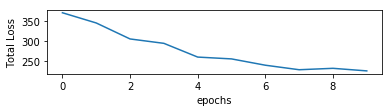

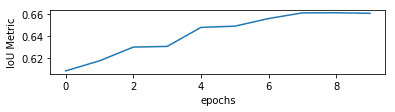

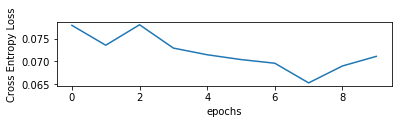

In [227]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [17]:
print(model.evaluate(X_test,y=[bb_y_test,labels_y_test],batch_size=3))

idx = 3
model.predict(np.expand_dims(X_train[idx],0))

445/445 [==============================] - 9s 20ms/step
[781.4123689115717, 781.331518348951, 0.08085473188984328, 0.7438202341620842, 0.5446495344464699, 0.7483146159836416]


[array([[ 15.957864,  18.848352, 156.70369 , 177.23734 ]], dtype=float32),
 array([[3.5003147e-16, 1.0000000e+00, 2.3328291e-27, 3.3107799e-26,
         4.4202381e-17, 3.6016291e-17]], dtype=float32)]

cod


/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


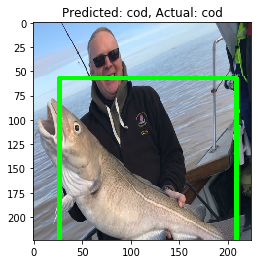

In [239]:
idx = np.random.randint(low=0,high=labels_y_test.shape[0])
bb,classify = model.predict(np.expand_dims(X_test[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(X_test[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(labels_y_test[idx])))
plt.imshow(pil_im)
print(label[0])

In [158]:
# model.load_weights('localize.hd5')
# idx = 100
# [[xmin,xmax, ymin,ymax]] = model.predict(np.expand_dims(X_test[idx],0))
# img = cv2.rectangle(X_test[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
# pil_im = Image.fromarray(img)
# plt.imshow(pil_im)

In [233]:
model.predict(np.expand_dims(X_test[idx],0))

array([[ 60.459423, 163.77663 ,  57.91272 , 197.88513 ]], dtype=float32)

In [30]:
# labels = []
# image_features = []

# labels_test = []
# image_features_test = []

# images = []
# image_count = 0
# for idx,label in enumerate(os.listdir("images")):
#     listdir = np.array(os.listdir("images/"+label))
#     print(label,len(listdir))
#     batch_sz = 100
#     features = []
#     labs = []
#     label_batches = []
    
#     labs_test = []
#     label_batches_test = []
#     count = 0
#     for file in listdir:
#         try:
#             path = "images/"+label+'/'+file
#             features.append(np.array(extract_image(path,model)[0]))
#         except:
#             count = count + 1
#     print("Count is",count)
#     temp_features = np.array(features)
#     print(temp_features.shape)
#     print("Done processing features")
#     for i in range(int(len(listdir)/batch_sz)):
#         X_features = temp_features[i*batch_sz:i*batch_sz+batch_sz]
#         X_train, X_test, _, _ = train_test_split(X_features,np.ones(batch_sz,dtype='int'),test_size=0.1,random_state=1000)
#         for aug_image in X_train:
#             aug_image = preprocess_input(aug_image)
#             transformed_features = vgg_model(np.expand_dims(aug_image, axis=0))
#             label_batches.append(transformed_features)
#             labs.append(label)
#         for aug_image in X_test:
#             images.append(aug_image)
#             aug_image = preprocess_input(aug_image)
#             transformed_features = vgg_model(np.expand_dims(aug_image, axis=0))
#             label_batches_test.append(transformed_features)
#             labs_test.append(label)
        
#     image_features = image_features + label_batches
#     labels = labels + labs

#     image_features_test = image_features_test + label_batches_test
#     labels_test = labels_test + labs_test
#     print(len(image_features_test))
#     print(len(images))

In [6]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)

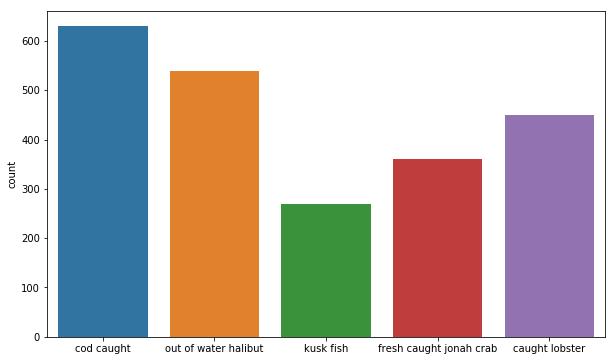

In [7]:
# plt.figure(figsize=(10,6))
# sns.countplot(labels)

In [32]:
# num_labels = len(np.unique(labels))
# image_f = np.squeeze(np.array(image_features),axis=1)
# image_f_test = np.squeeze(np.array(image_features_test),axis=1)
# num_of_train_examples = image_f.shape
# print(num_of_train_examples)
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(list(labels)+list(labels_test))
# #le.fit(list(labels))
# le_labels = le.transform(labels)
# le_labels_test = le.transform(labels_test)
# one = preprocessing.OneHotEncoder()
# #one.fit(list(le_labels.reshape(-1,1)))
# one.fit(list(le_labels.reshape(-1,1))+list(le_labels_test.reshape(-1,1)))
# one_labels = one.transform(le_labels.reshape(-1,1))
# one_labels_test = one.transform(le_labels_test.reshape(-1,1))

In [9]:
# image_input = Input(shape=(4096,))
# img_input = BatchNormalization()(image_input)
# img_input = Dense(2048,activation='softmax')(img_input)
# img_input = BatchNormalization()(image_input)
# output = Dense(num_labels,activation='softmax')(img_input)
# model_dense = Model(image_input, output)
# model_dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# model_dense.save_weights('vgg.hd5')

In [10]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5,shuffle=True,random_state=1000)
# test_cvscores = []
# validation_cvscores = []
# for train, test in kf.split(image_f):
#     model_dense.load_weights('vgg.hd5')
#     hist = model_dense.fit(image_f[train], one_labels[train], epochs=10, verbose=1,class_weight=class_weights)
#     print(hist.history['loss'])
#     validation_score = model_dense.evaluate(image_f[test], one_labels[test], verbose=0)
#     test_score = model_dense.evaluate(image_f_test, one_labels_test, verbose=0)
#     predictions = model_dense.predict(image_f_test, verbose=0)
#     pred_labels = np.argmax(predictions,axis=1)
#     predicted_labels = le.inverse_transform(pred_labels)
#     test_cvscores.append(test_score)
#     validation_cvscores.append(validation_score)

Epoch 1/10
1800/1800 [==============================] - 0s 129us/step - loss: 0.8716 - acc: 0.7139
Epoch 2/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.4034 - acc: 0.8544
Epoch 3/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.2466 - acc: 0.9072
Epoch 4/10
1800/1800 [==============================] - 0s 85us/step - loss: 0.1886 - acc: 0.9333
Epoch 5/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.1364 - acc: 0.9561
Epoch 6/10
1800/1800 [==============================] - 0s 87us/step - loss: 0.1140 - acc: 0.9639
Epoch 7/10
1800/1800 [==============================] - 0s 89us/step - loss: 0.0968 - acc: 0.9667
Epoch 8/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.0725 - acc: 0.9800
Epoch 9/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.0749 - acc: 0.9756
Epoch 10/10
1800/1800 [==============================] - 0s 87us/step - loss: 0.0780 - acc: 0.9817
[0.871630490620931

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1800/1800 [==============================] - 0s 84us/step - loss: 0.3695 - acc: 0.8672
Epoch 3/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.2340 - acc: 0.9144
Epoch 4/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.1353 - acc: 0.9517
Epoch 5/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.1124 - acc: 0.9683
Epoch 6/10
1800/1800 [==============================] - 0s 85us/step - loss: 0.0889 - acc: 0.9756
Epoch 7/10
1800/1800 [==============================] - 0s 89us/step - loss: 0.0881 - acc: 0.9728
Epoch 8/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.0602 - acc: 0.9883
Epoch 9/10
1800/1800 [==============================] - 0s 85us/step - loss: 0.0670 - acc: 0.9850
Epoch 10/10
1800/1800 [==============================] - 0s 85us/step - loss: 0.0641 - acc: 0.9822
[0.9228925593694051, 0.3694726079040104, 0.23404352956347996, 0.1352503557668792, 0.11239309863911735, 0.08892834997839398, 0.08

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1800/1800 [==============================] - 0s 85us/step - loss: 0.3725 - acc: 0.8717
Epoch 3/10
1800/1800 [==============================] - 0s 83us/step - loss: 0.2090 - acc: 0.9183
Epoch 4/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.1275 - acc: 0.9550
Epoch 5/10
1800/1800 [==============================] - 0s 83us/step - loss: 0.0992 - acc: 0.9694
Epoch 6/10
1800/1800 [==============================] - 0s 85us/step - loss: 0.0899 - acc: 0.9717
Epoch 7/10
1800/1800 [==============================] - 0s 83us/step - loss: 0.0597 - acc: 0.9911
Epoch 8/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.0634 - acc: 0.9844
Epoch 9/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0430 - acc: 0.9922
Epoch 10/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0350 - acc: 0.9939
[0.9198805999755859, 0.3724915831618839, 0.20899589697519938, 0.1275390633278423, 0.09915371984243393, 0.08989941149950027, 0.05

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1800/1800 [==============================] - 0s 85us/step - loss: 0.3511 - acc: 0.8633
Epoch 3/10
1800/1800 [==============================] - 0s 83us/step - loss: 0.2278 - acc: 0.9122
Epoch 4/10
1800/1800 [==============================] - 0s 85us/step - loss: 0.1184 - acc: 0.9600
Epoch 5/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0769 - acc: 0.9761
Epoch 6/10
1800/1800 [==============================] - 0s 83us/step - loss: 0.0620 - acc: 0.9861
Epoch 7/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0662 - acc: 0.9844
Epoch 8/10
1800/1800 [==============================] - 0s 85us/step - loss: 0.0610 - acc: 0.9822
Epoch 9/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0595 - acc: 0.9861
Epoch 10/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.0403 - acc: 0.9917
[0.9463311261600919, 0.35108840147654213, 0.22776376850075192, 0.1184261268377304, 0.07690137339962853, 0.06202534733547105, 0.0

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1800/1800 [==============================] - 0s 84us/step - loss: 0.3468 - acc: 0.8711
Epoch 3/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.2113 - acc: 0.9233
Epoch 4/10
1800/1800 [==============================] - 0s 86us/step - loss: 0.1033 - acc: 0.9683
Epoch 5/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0738 - acc: 0.9767
Epoch 6/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0685 - acc: 0.9817
Epoch 7/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0617 - acc: 0.9822
Epoch 8/10
1800/1800 [==============================] - 0s 85us/step - loss: 0.0703 - acc: 0.9794
Epoch 9/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0433 - acc: 0.9906
Epoch 10/10
1800/1800 [==============================] - 0s 84us/step - loss: 0.0381 - acc: 0.9922
[0.8626071704758538, 0.34680964721573726, 0.21127604107062023, 0.10326823314030965, 0.07383859564860662, 0.06845141059822506, 0.

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [11]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

0.8215999979972839
0.009666437347147587
0.7946666666666667
0.018887581654111803


In [21]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(np.array(test_cvscores)[:,1]*100)

[82.00 78.40 78.80 80.00 78.40]


In [22]:
#print("Validation Standard Deviation",np.std(validation_cvscores))
print("Test Standard Deviation",np.std(test_cvscores))

Test Standard Deviation 0.31310995300158423


In [13]:
test_score

[0.7332952129840851, 0.8239999976158142]

In [15]:
# f, axarr = plt.subplots(num_labels,2)
# f.set_figheight(30)
# f.set_figwidth(30)
# for i in range(num_labels):
#     axarr[i,0].imshow(mpimg.imread(images_to_show[i][0]))
#     axarr[i,0].title.set_text("train "+images_to_show[i][2])
#     axarr[i,1].imshow(mpimg.imread(images_to_show[i][1]))
#     axarr[i,1].title.set_text("test "+images_to_show[i][2])
# plt.show()
# plt.savefig('transferlearning.png')
# # import matplotlib.pyplot as plt
# # import matplotlib.image as mpimg
# # image = mpimg.imread(images[0])
# # plt.imshow(image)
# # plt.show()

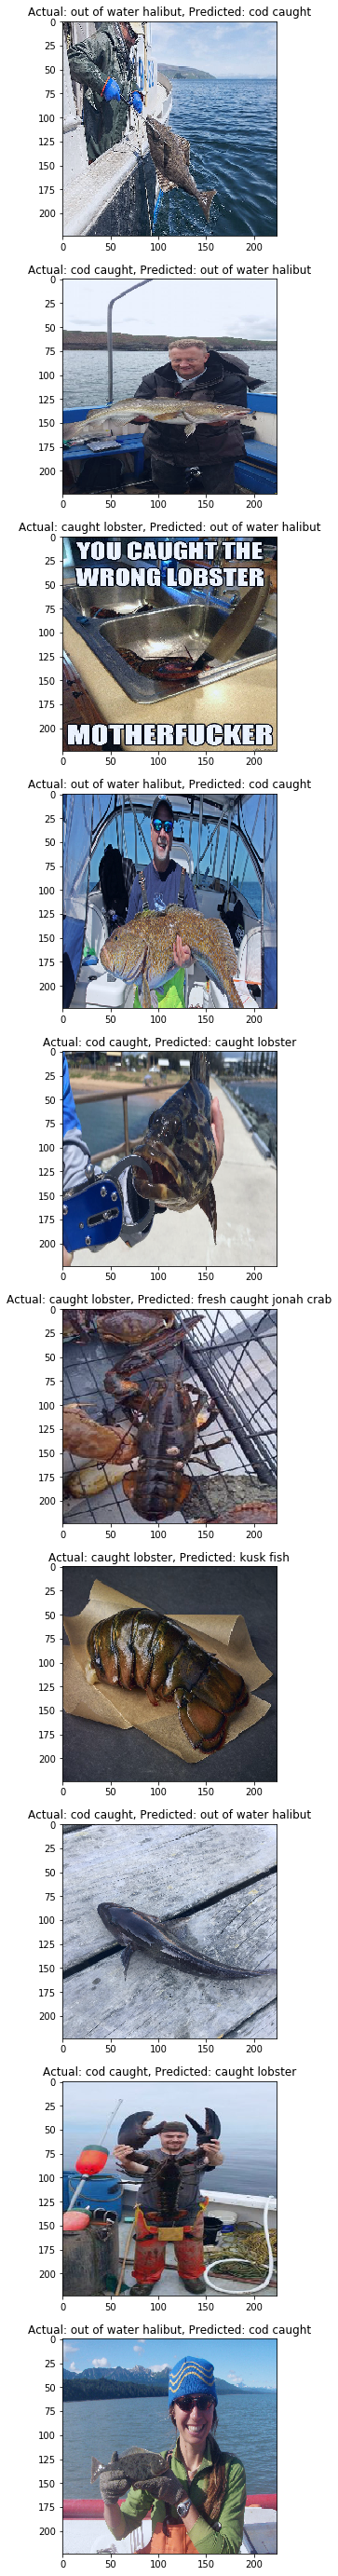

In [16]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

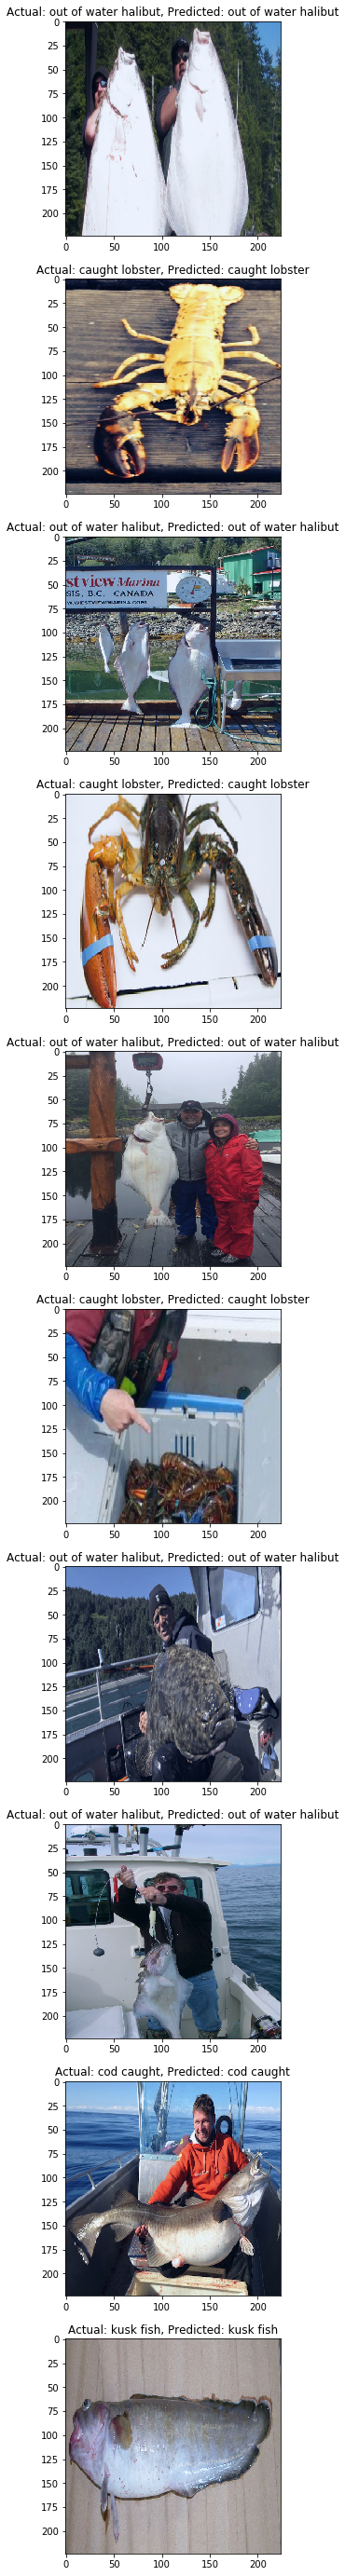

In [17]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [1]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()